In [1]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import ta

In [2]:
# --- Load Data ---
pair = "ETH/USDT"
tf = "1h"

df = get_historical_from_db(ccxt.binance(),pair,tf,path="../../database/")
df

,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029
...,...,...,...,...,...
2022-05-01 08:00:00,2766.40,2782.00,2765.18,2778.31,12854.70750
2022-05-01 09:00:00,2778.31,2780.64,2756.80,2768.31,8475.55070
2022-05-01 10:00:00,2768.32,2775.87,2761.00,2766.42,8231.25800


In [3]:
#dfTest = df['2020-07-16':]
dfTest = df.copy()

dfTest['EMA28']=ta.trend.ema_indicator(dfTest['close'], 28)
dfTest['EMA48']=ta.trend.ema_indicator(dfTest['close'], 48)
dfTest['STOCH_RSI']=ta.momentum.stochrsi(dfTest['close'])

dfTest

,open,high,low,close,volume,EMA28,EMA48,STOCH_RSI
date,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877,NaN,NaN,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,NaN,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,NaN,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,NaN,NaN,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-05-01 08:00:00,2766.40,2782.00,2765.18,2778.31,12854.70750,2791.869325,2811.692491,0.994171
2022-05-01 09:00:00,2778.31,2780.64,2756.80,2768.31,8475.55070,2790.244544,2809.921777,0.857287
2022-05-01 10:00:00,2768.32,2775.87,2761.00,2766.42,8231.25800,2788.601472,2808.146195,0.831199


Period : [2017-08-17 04:00:00] -> [2022-05-01 12:00:00]
Starting balance : 1000 $
Final balance : 61899.04 $
Performance vs US Dollar : 6089.9 %
Buy and Hold Performence : 815.75 %
Performance vs Buy and Hold : 646.54 %
Number of negative trades :  199
Number of positive trades :  107
Average Positive Trades :  10.65 %
Average Negative Trades :  -2.82 %
Best trade +65.08 %, the  2018-01-11 14:00:00
Worst trade -13.82 %, the  2021-12-04 06:00:00
Worst drawBack -63.0 %
Total fee :  16192.34 $
PLOT


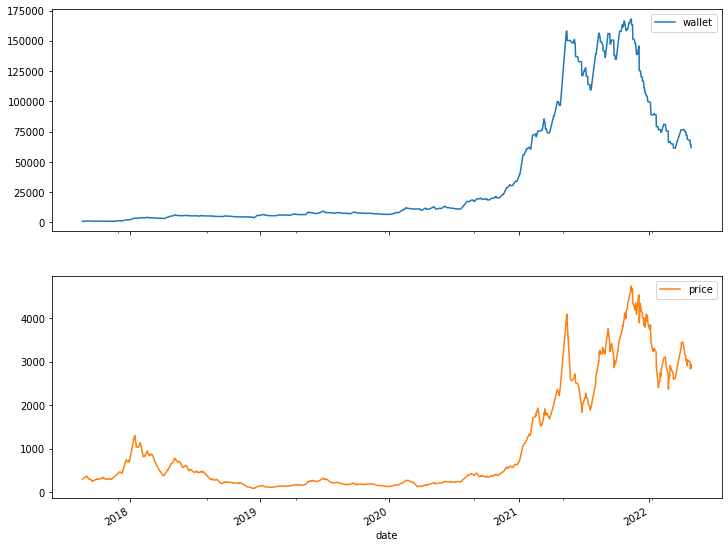

In [4]:
dt = None
dt = pd.DataFrame(columns = ['date','position', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 1000
initalWallet = usdt
coin = 0
wallet = 1000
lastAth = 0
lastIndex = df.first_valid_index()
fee = 0.0007

for index, row in dfTest.iterrows():
  #Buy
  if row['EMA28'] > row['EMA48'] and row['STOCH_RSI'] < 0.8 and  usdt > 0:
    coin = usdt / row['close']
    frais = fee * coin
    coin = coin - frais
    usdt = 0
    wallet = coin * row['close']
    if wallet > lastAth:
      lastAth = wallet
    # print("Buy COIN at",df['close'][index],'$ the', index)
    myrow = {'date': index,'position': "Buy",'price': row['close'],'frais': frais * row['close'],'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)

  #Sell
  if row['EMA28'] < row['EMA48'] and row['STOCH_RSI'] > 0.2 and coin > 0:
    usdt = coin * row['close']
    frais = fee * usdt
    usdt = usdt - frais
    coin = 0
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at",df['close'][index],'$ the', index)
    myrow = {'date': index,'position': "Sell",'price': row['close'],'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  lastIndex = index

#///////////////////////////////////////
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 1000 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")

dt[['wallet','price']].plot(subplots=True, figsize=(12,10))
print('PLOT')